In [12]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib
# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, headscanner_training_dataset, headscanner_validation_dataset
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim

import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

In [2]:
device = torch.device('cpu')

In [3]:
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

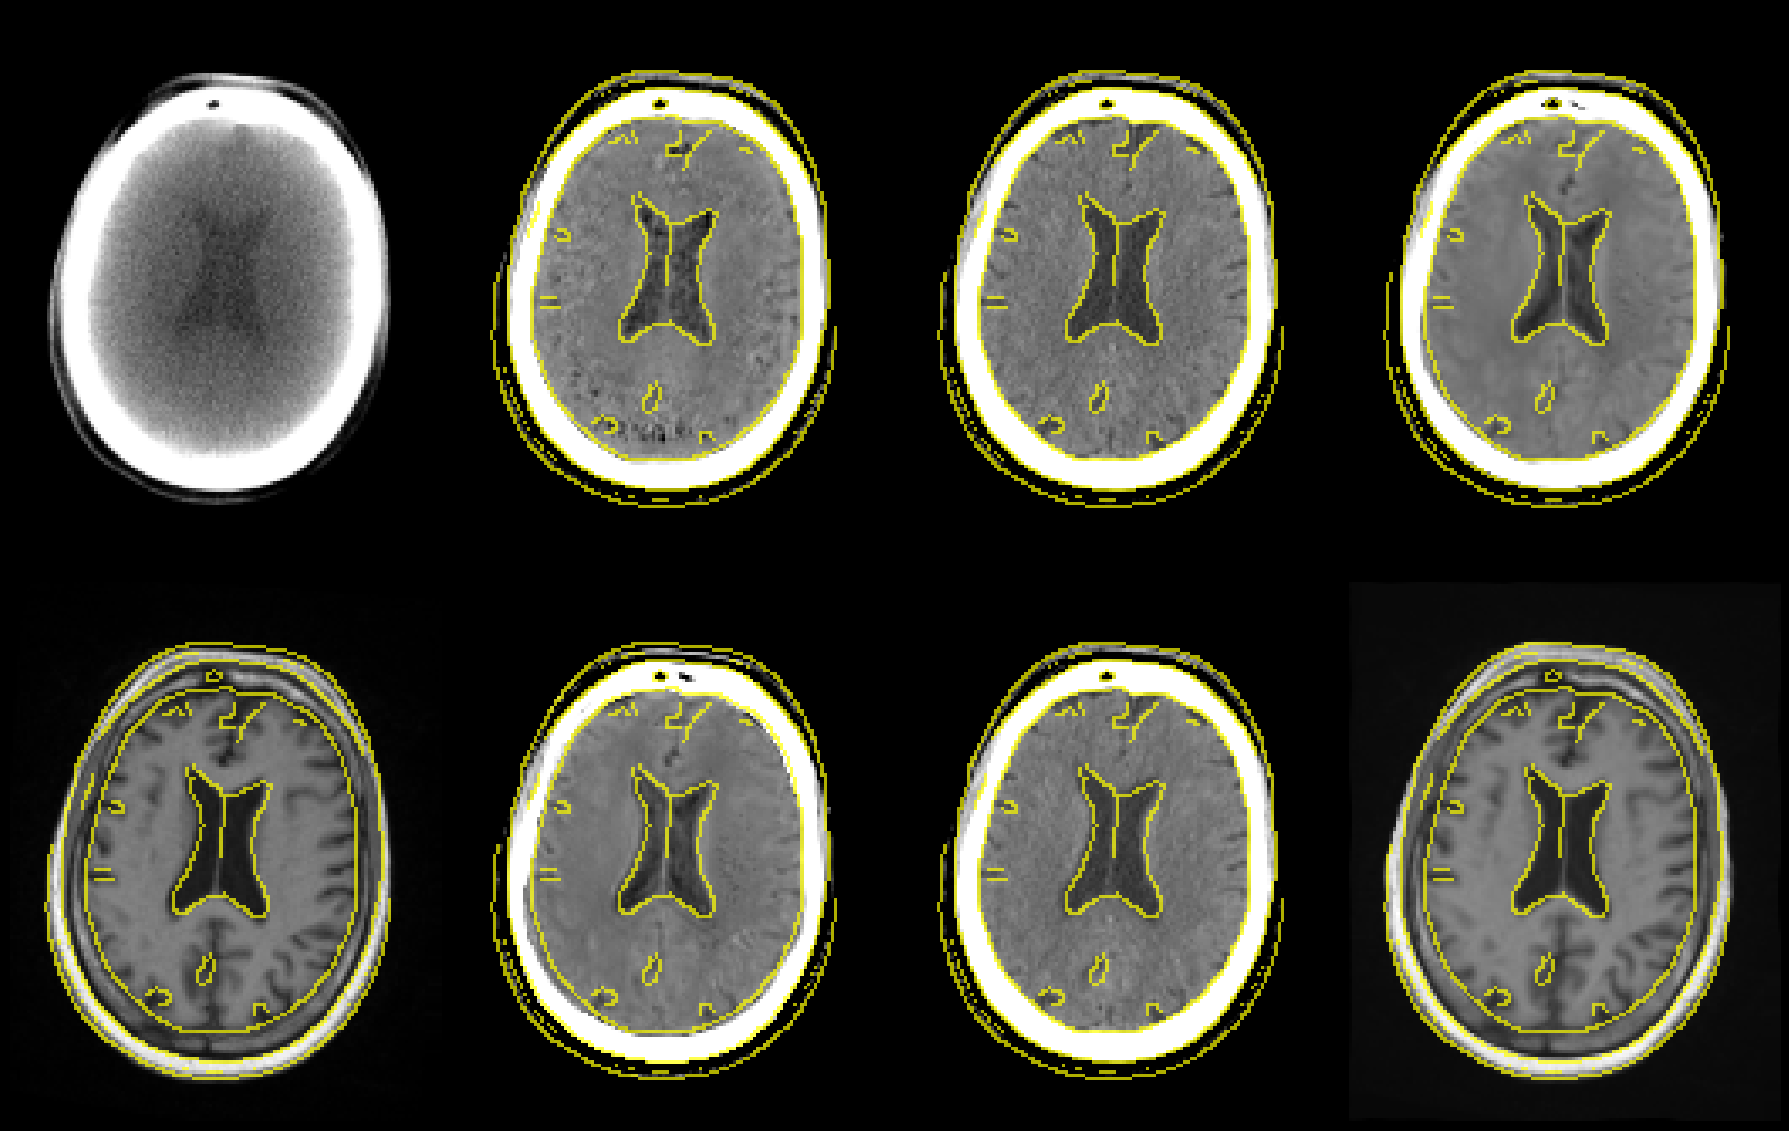

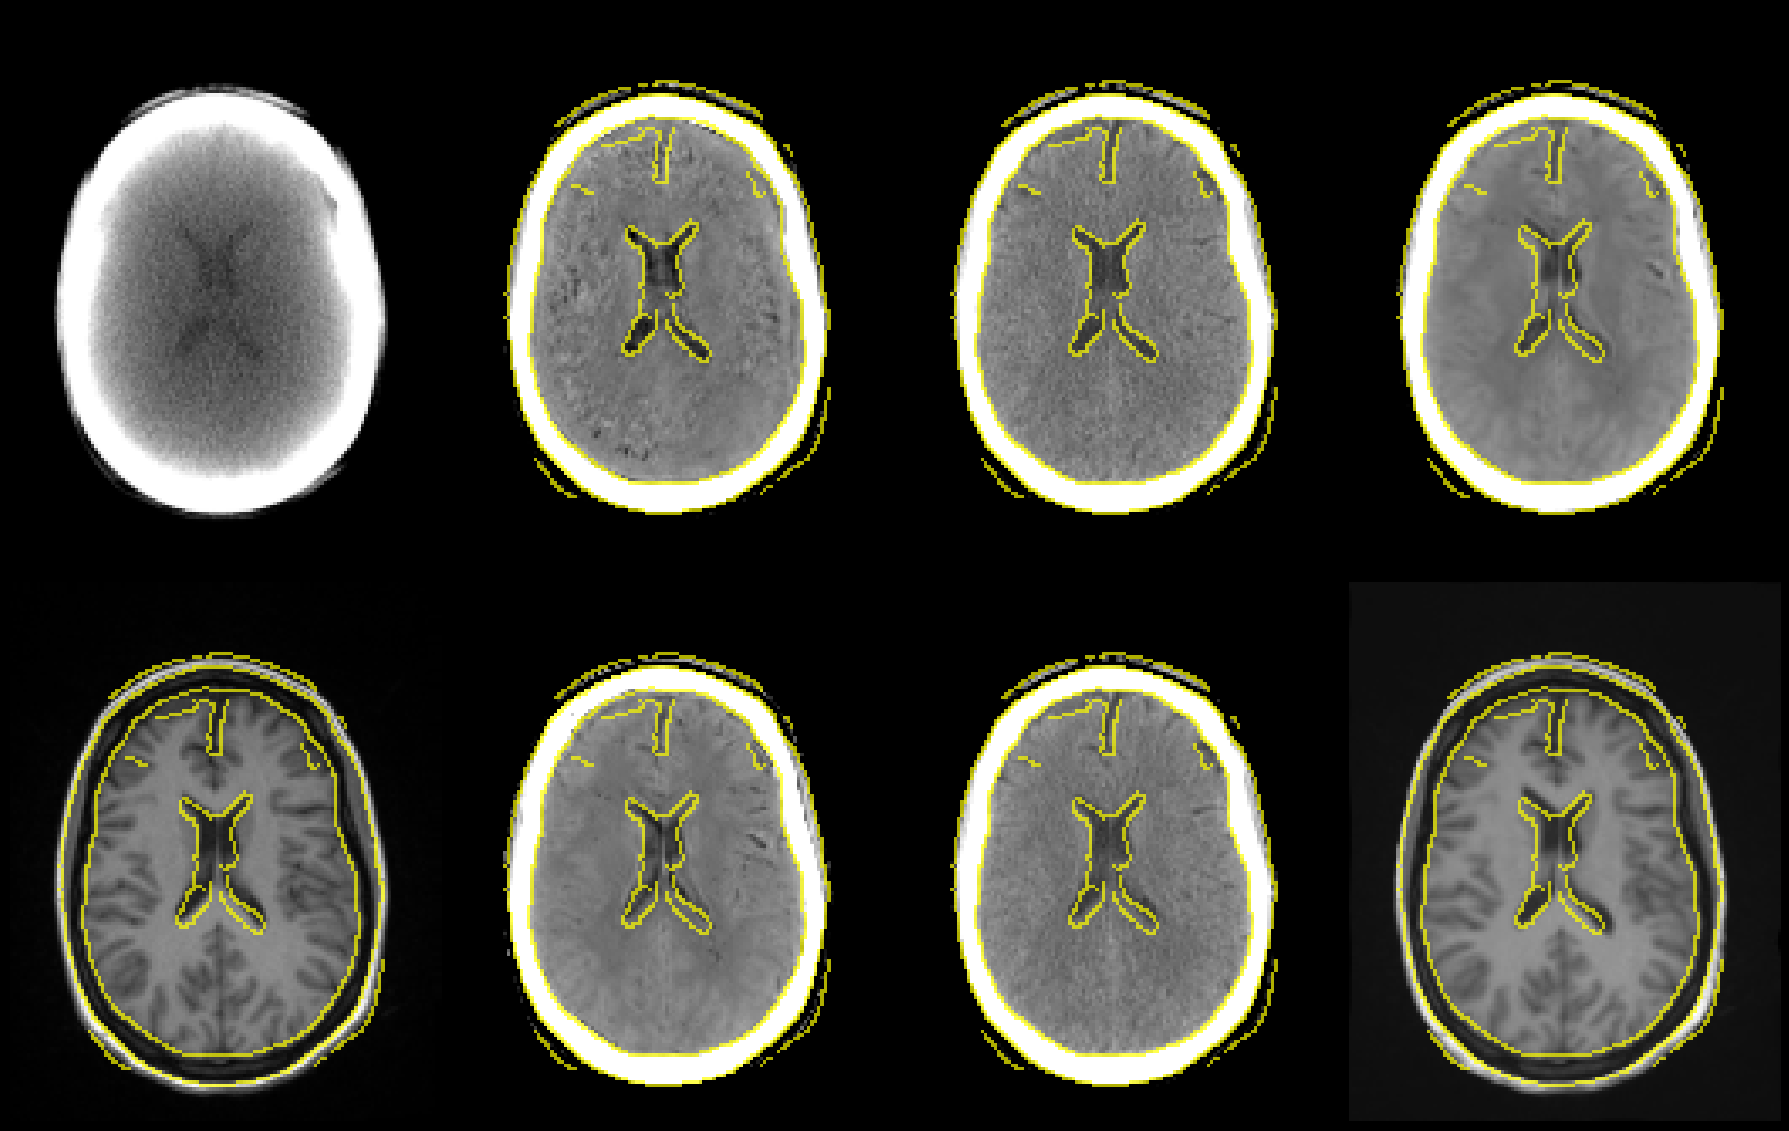

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


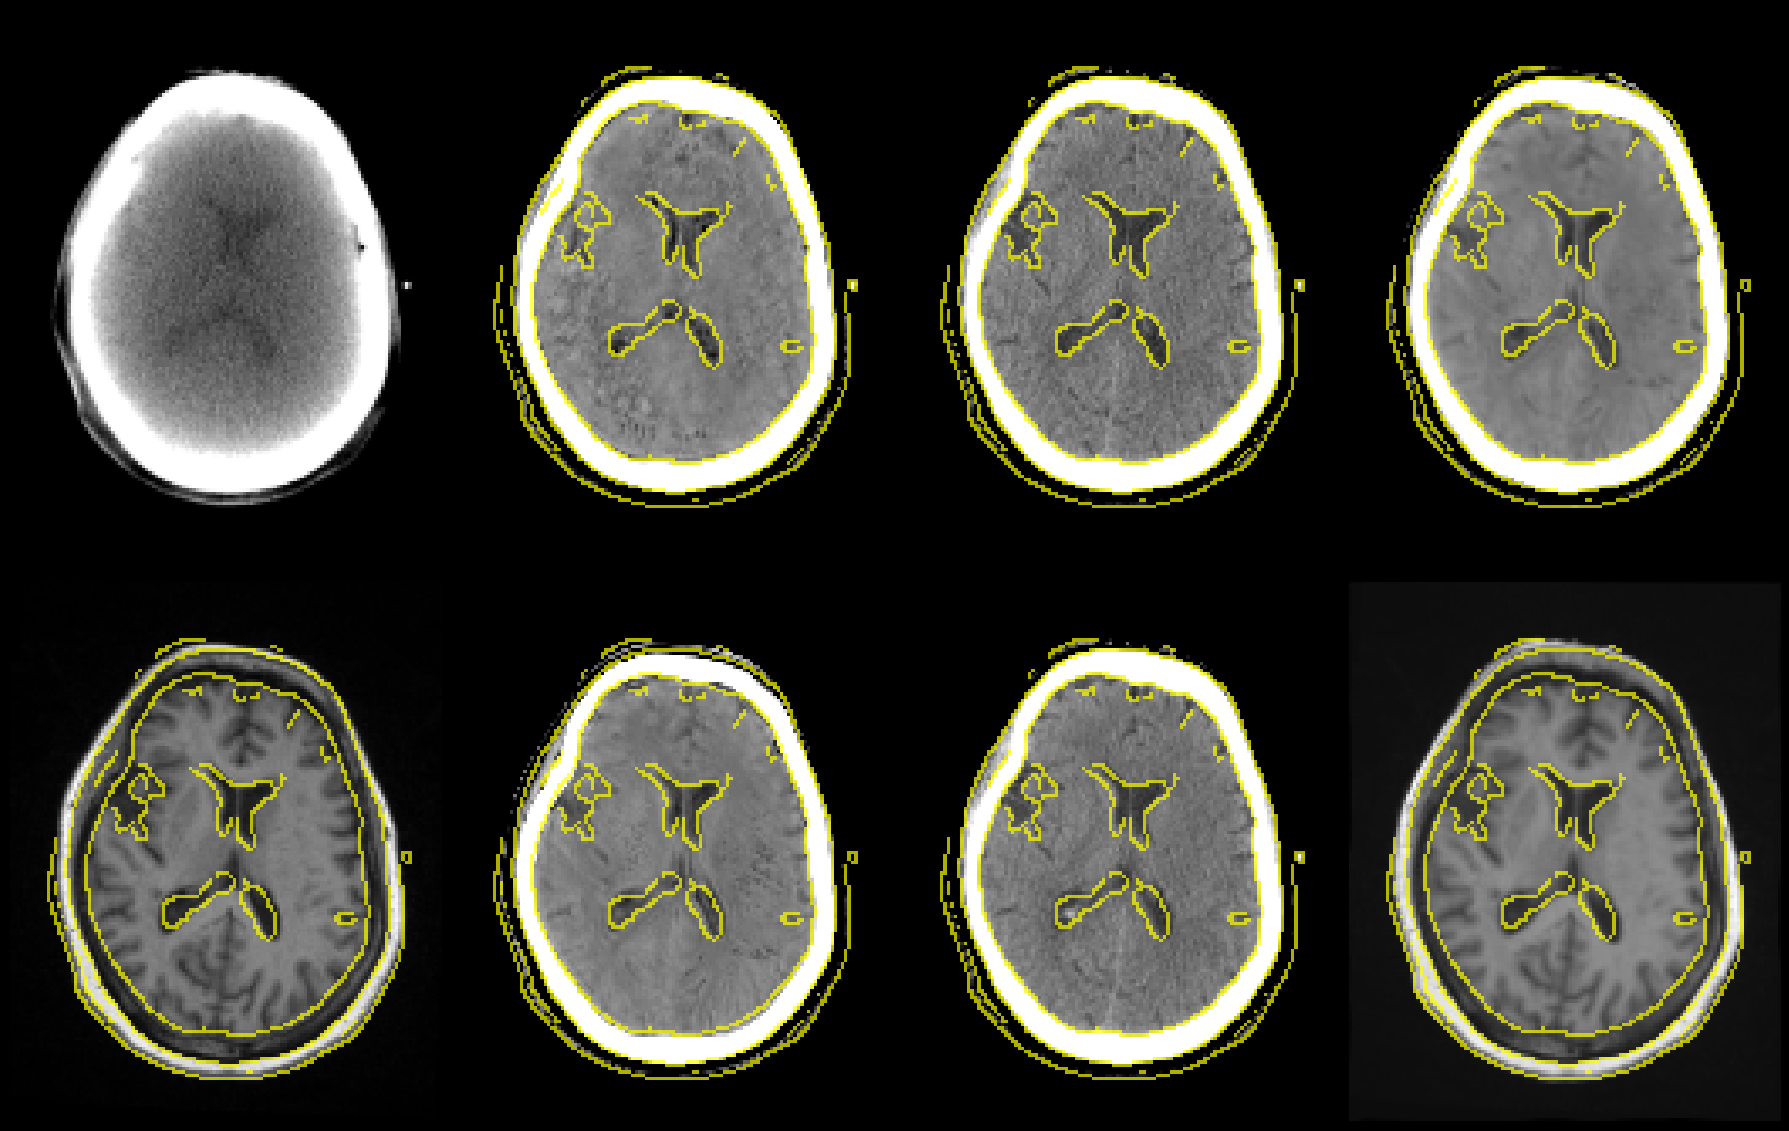

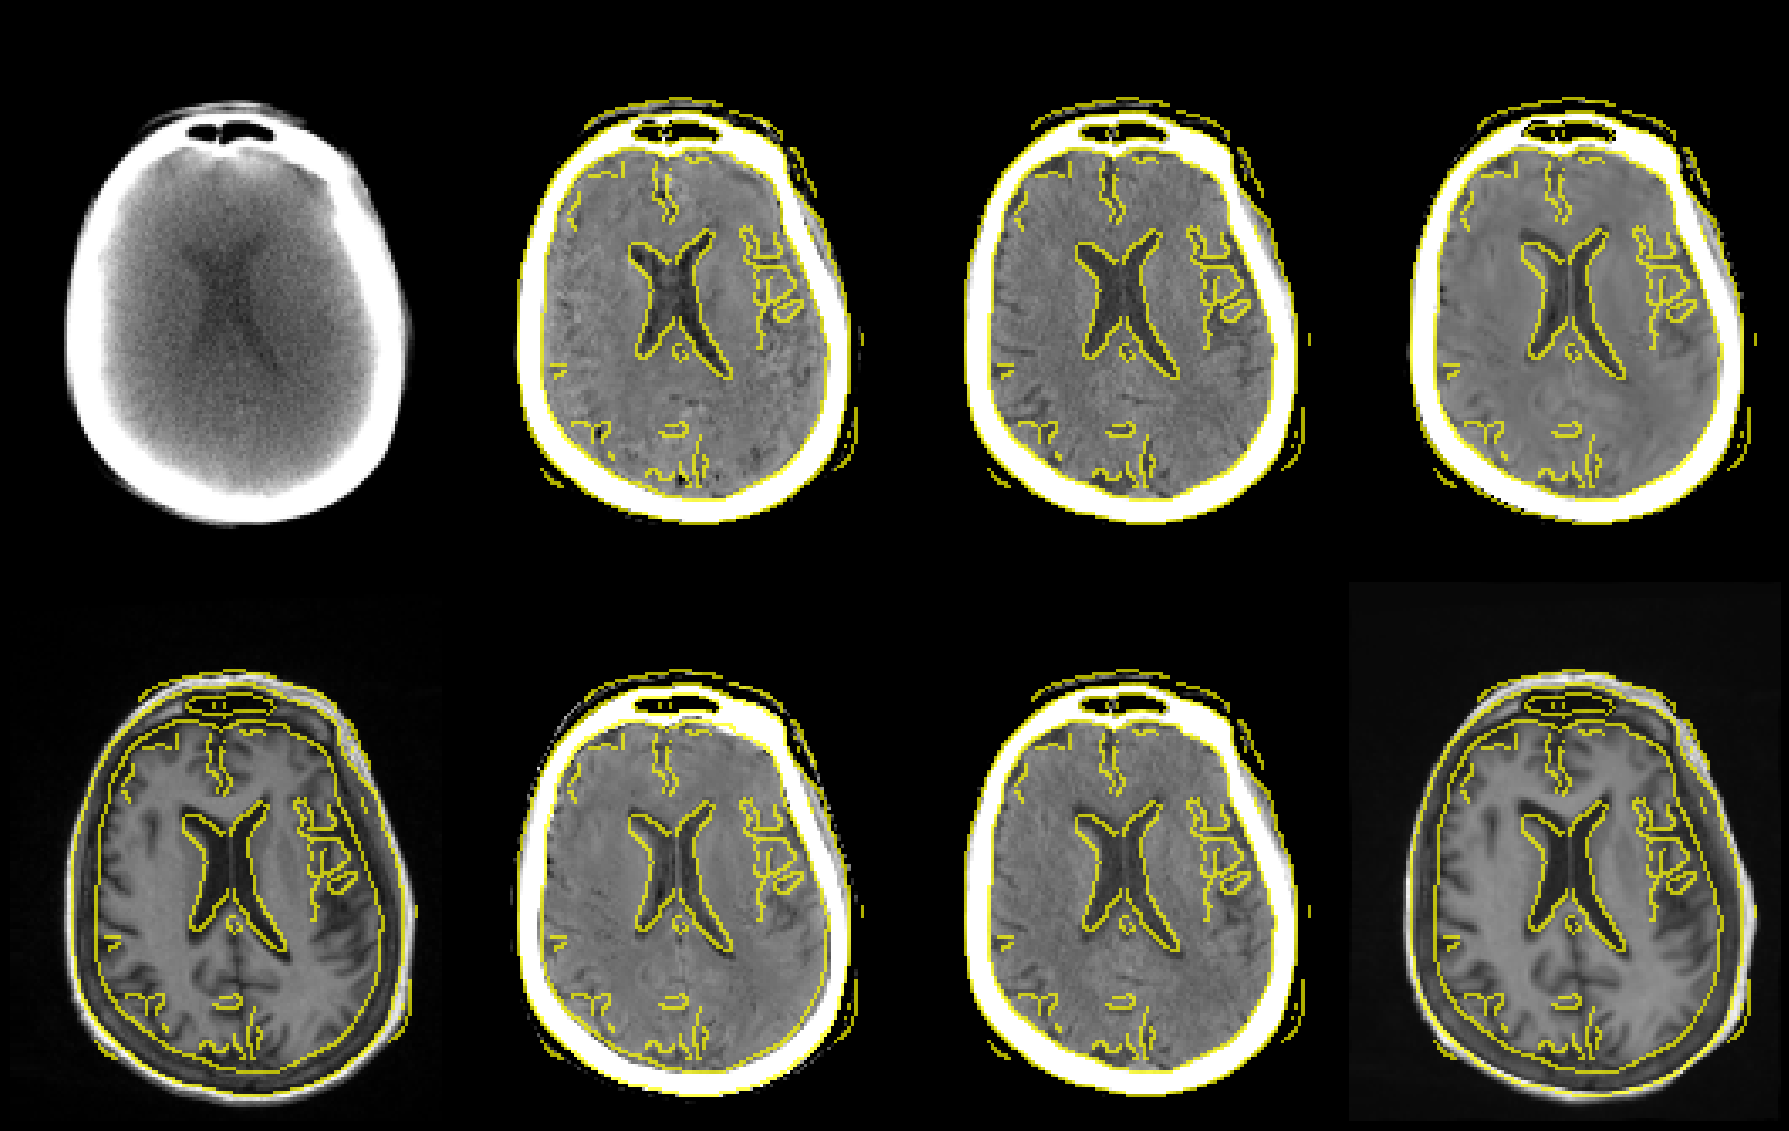

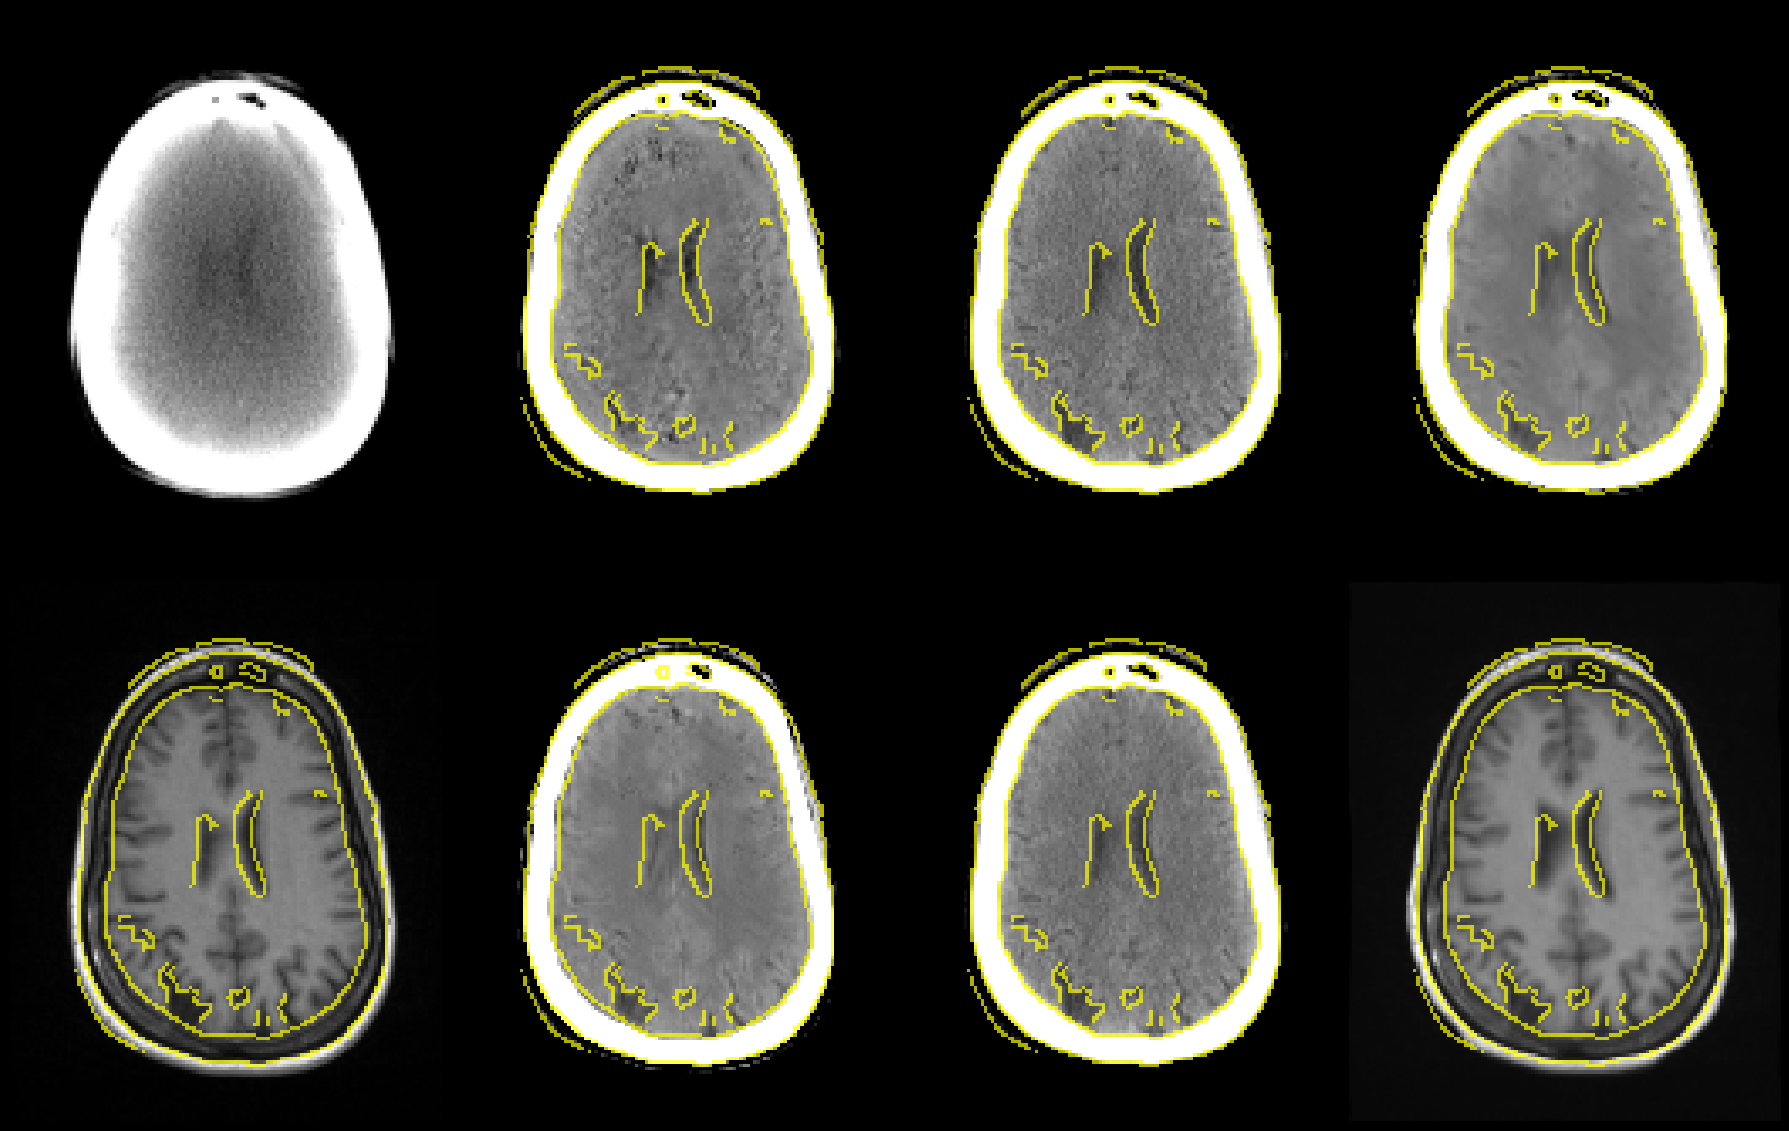

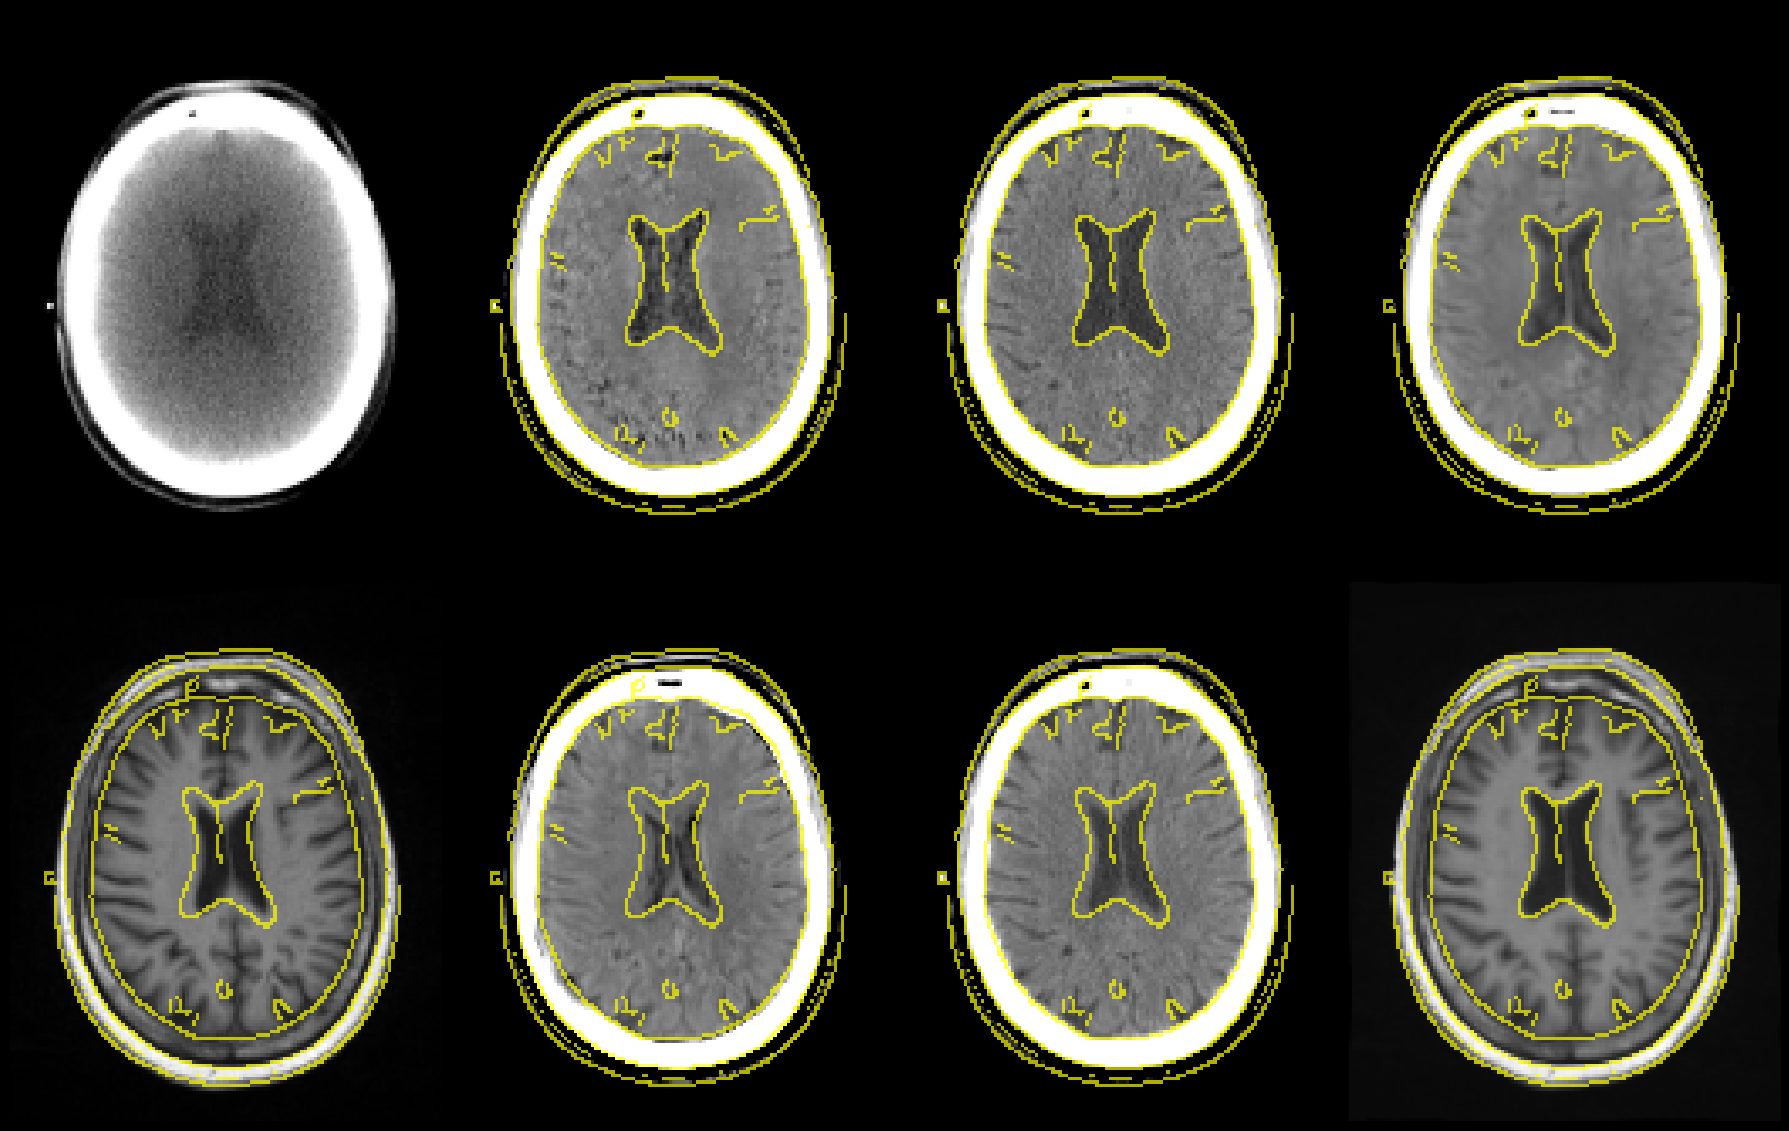

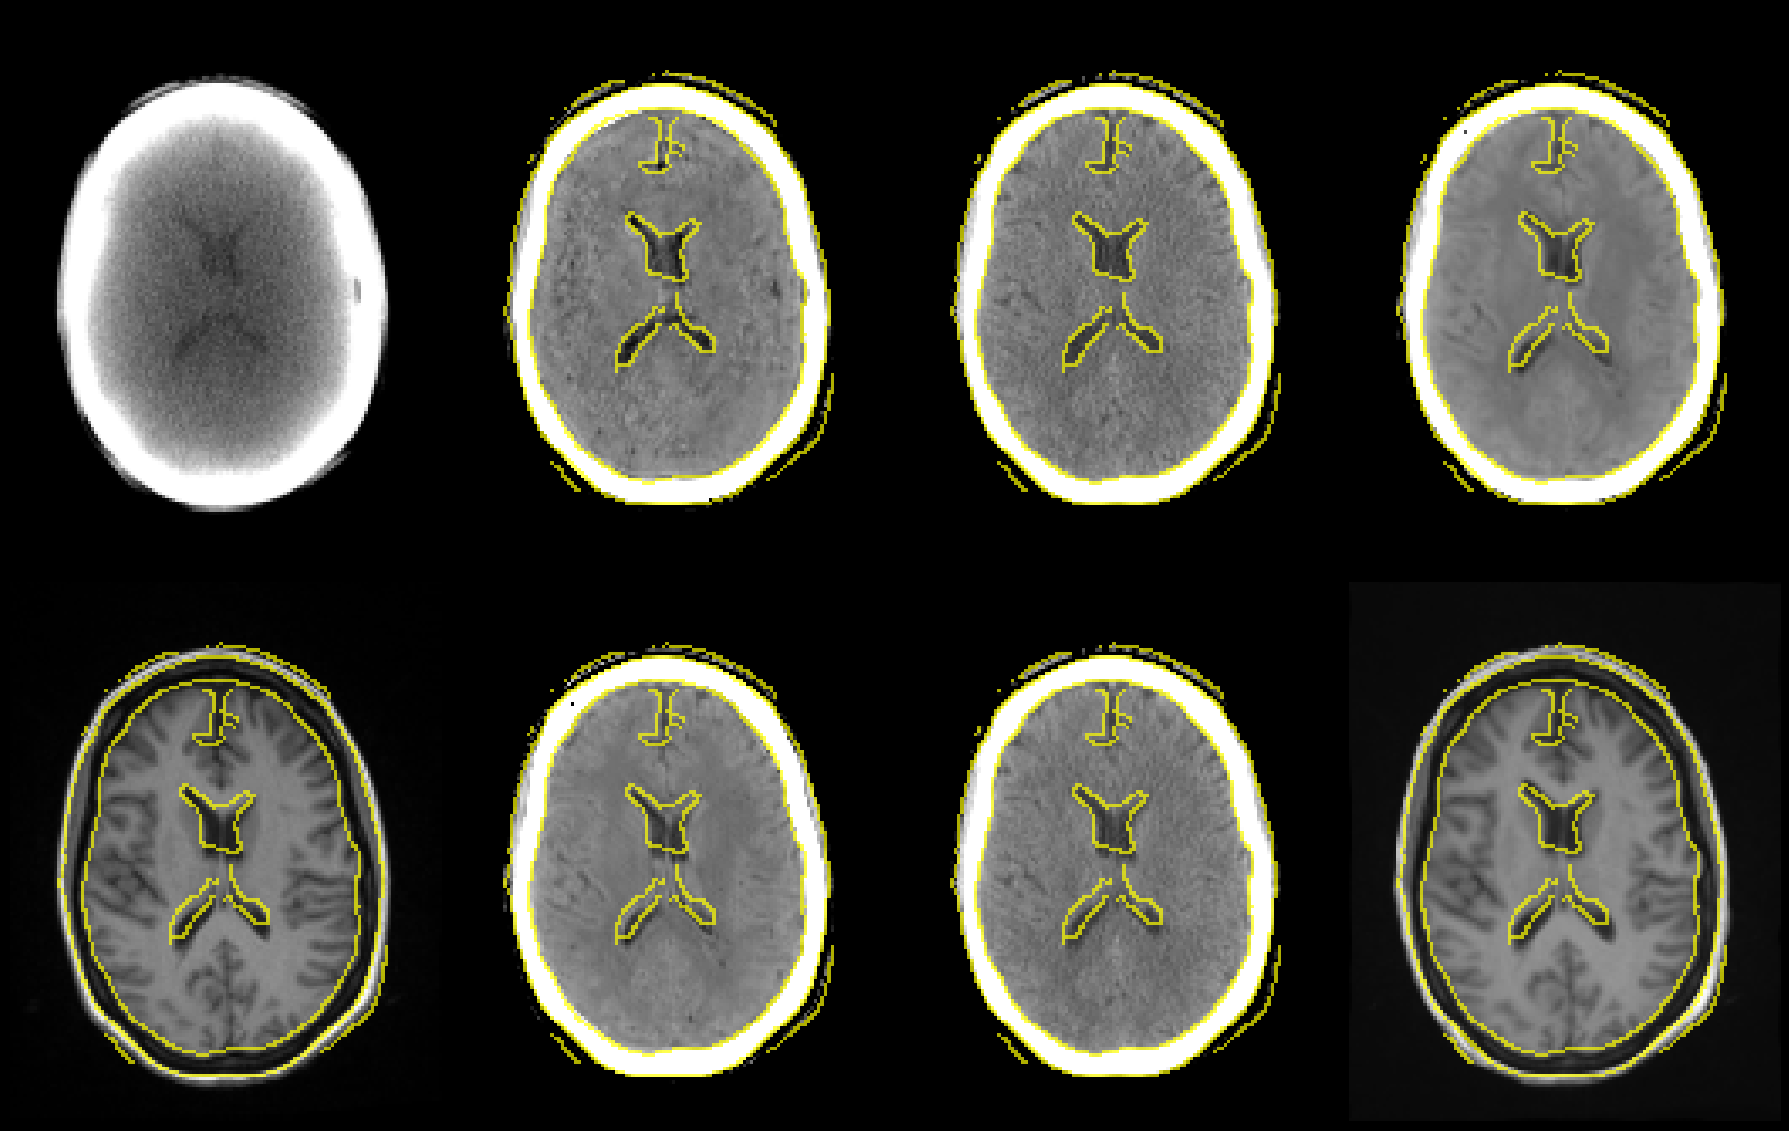

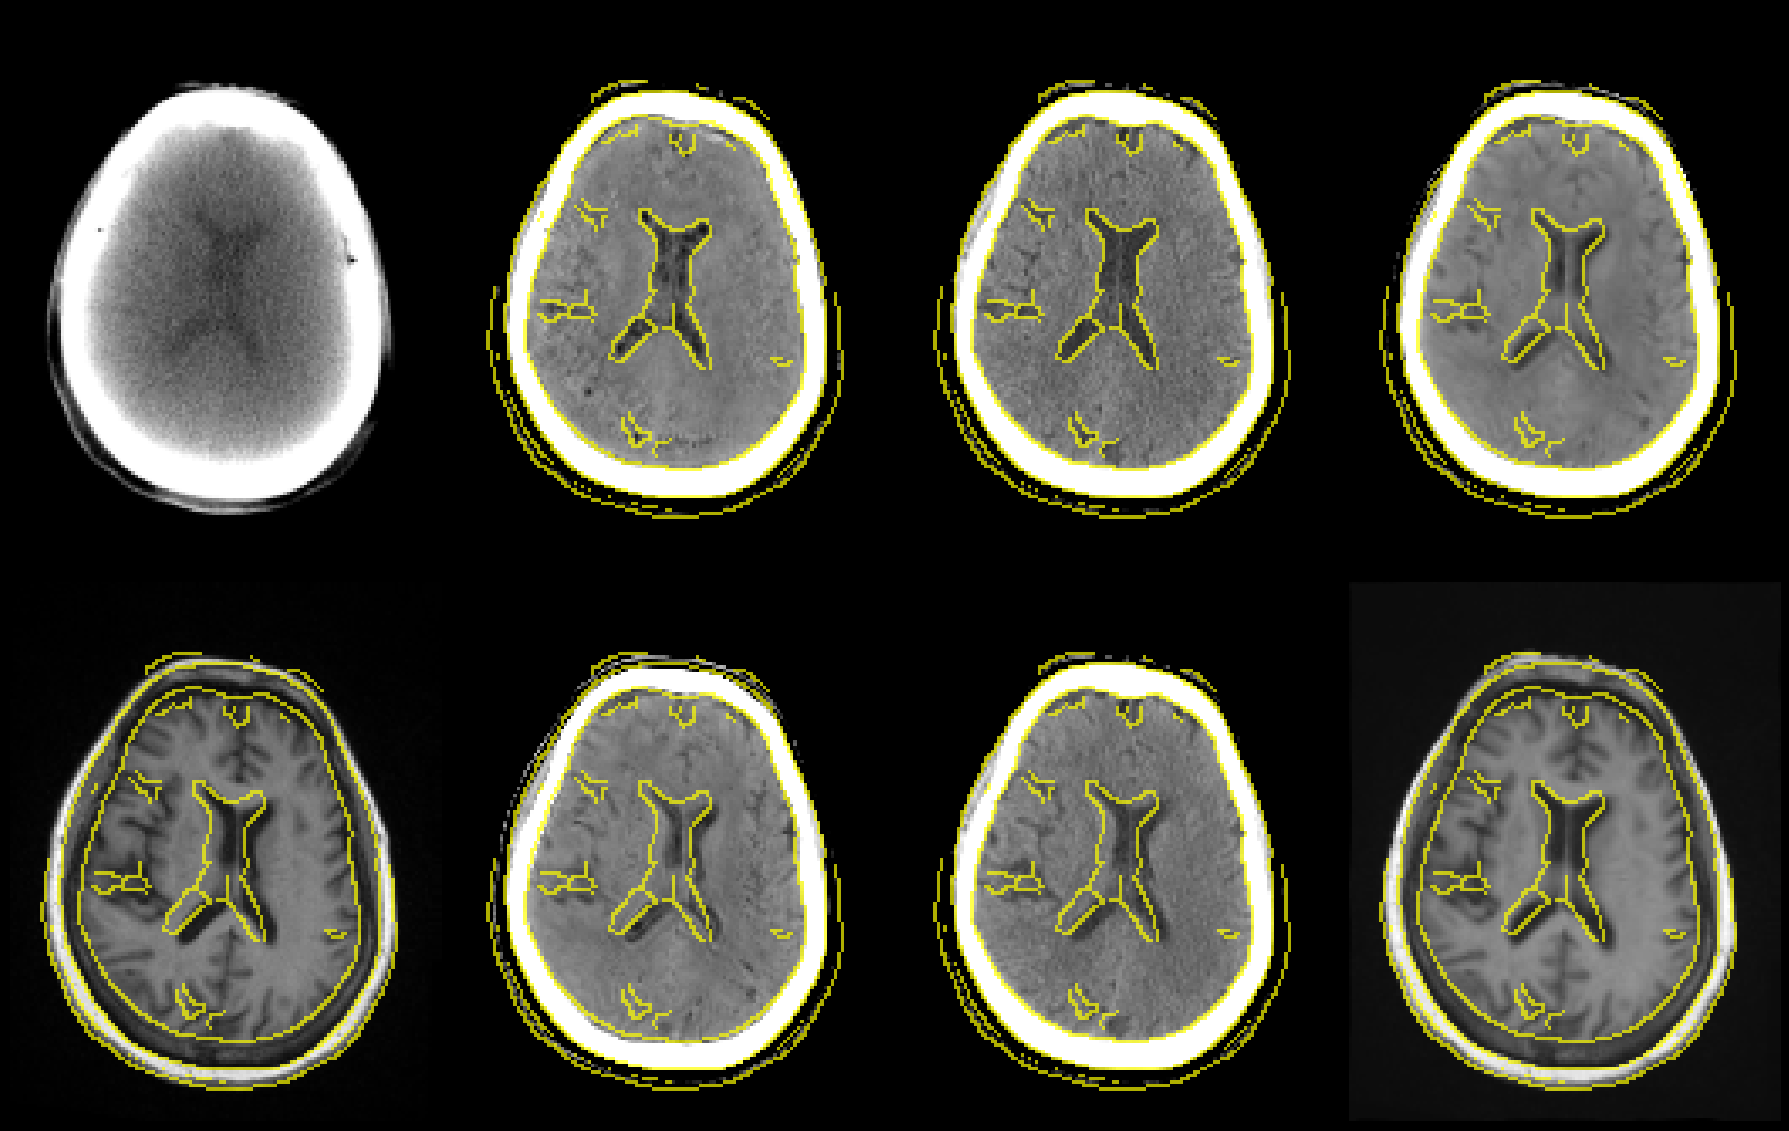

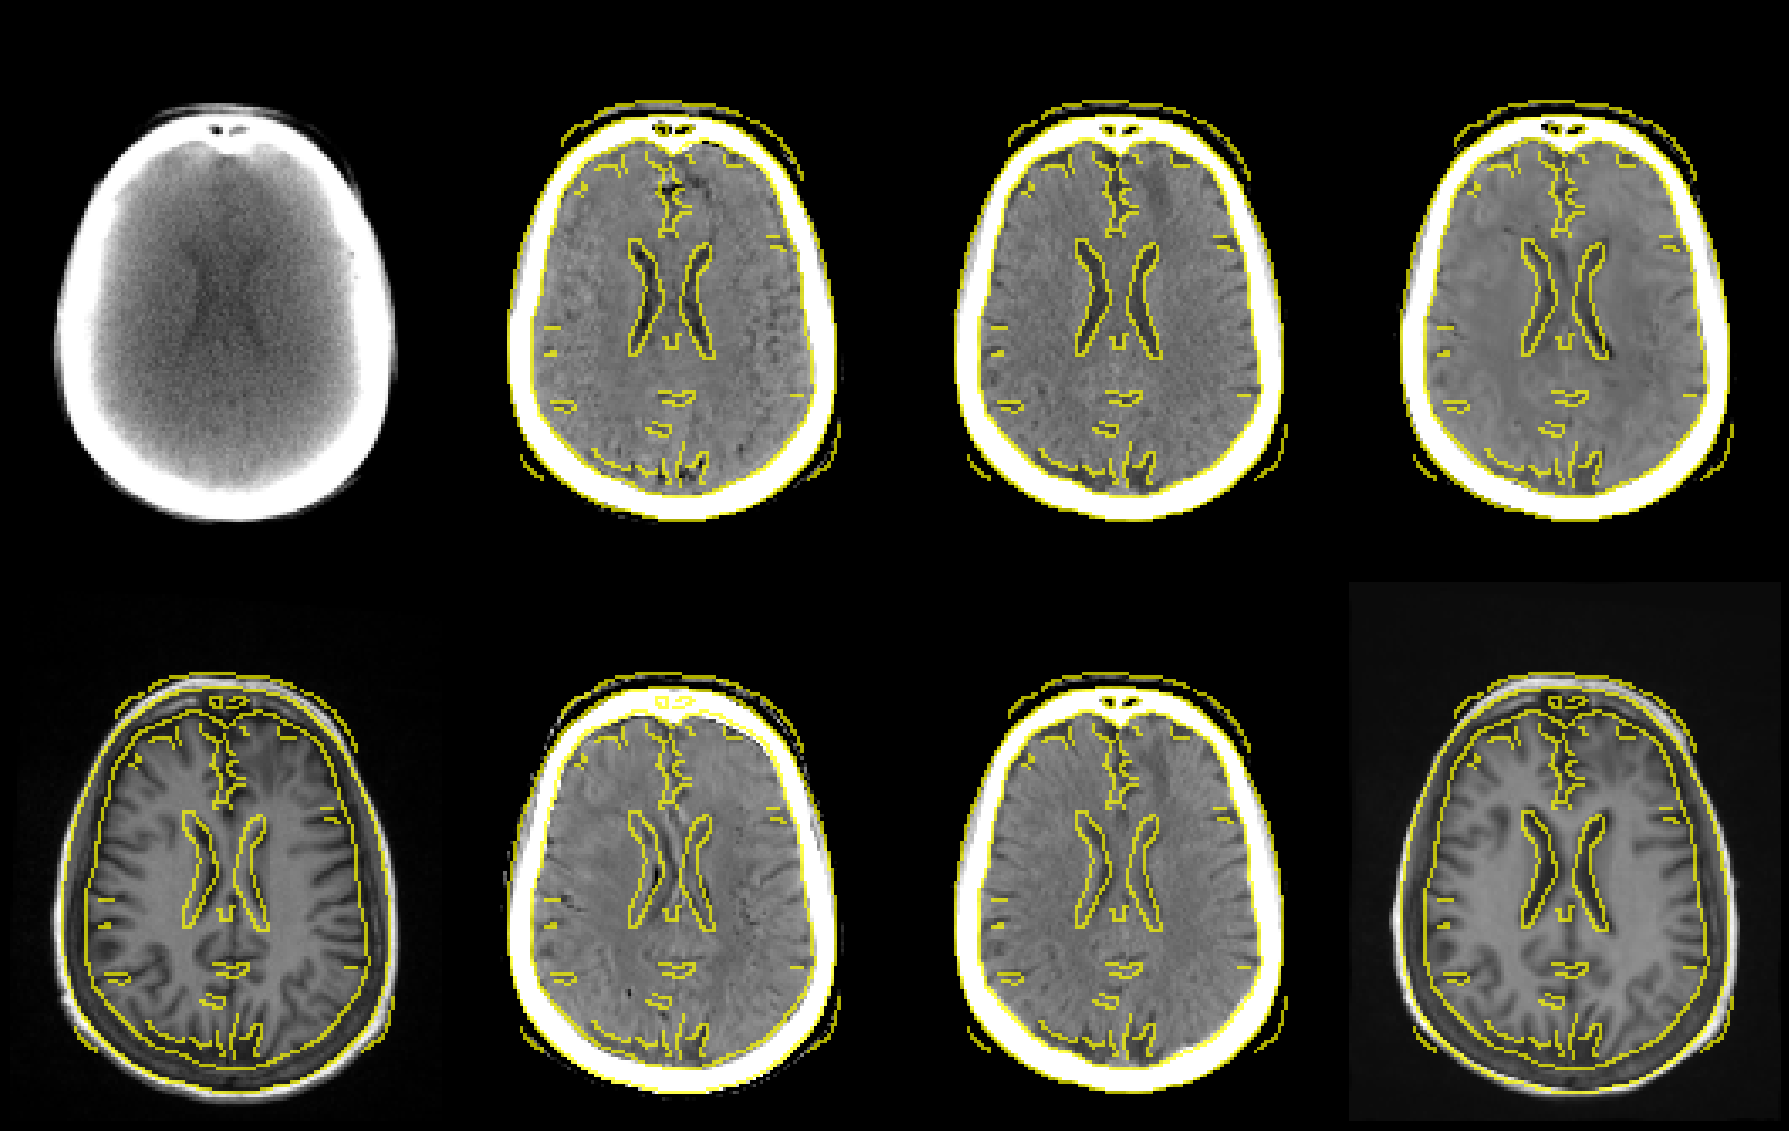

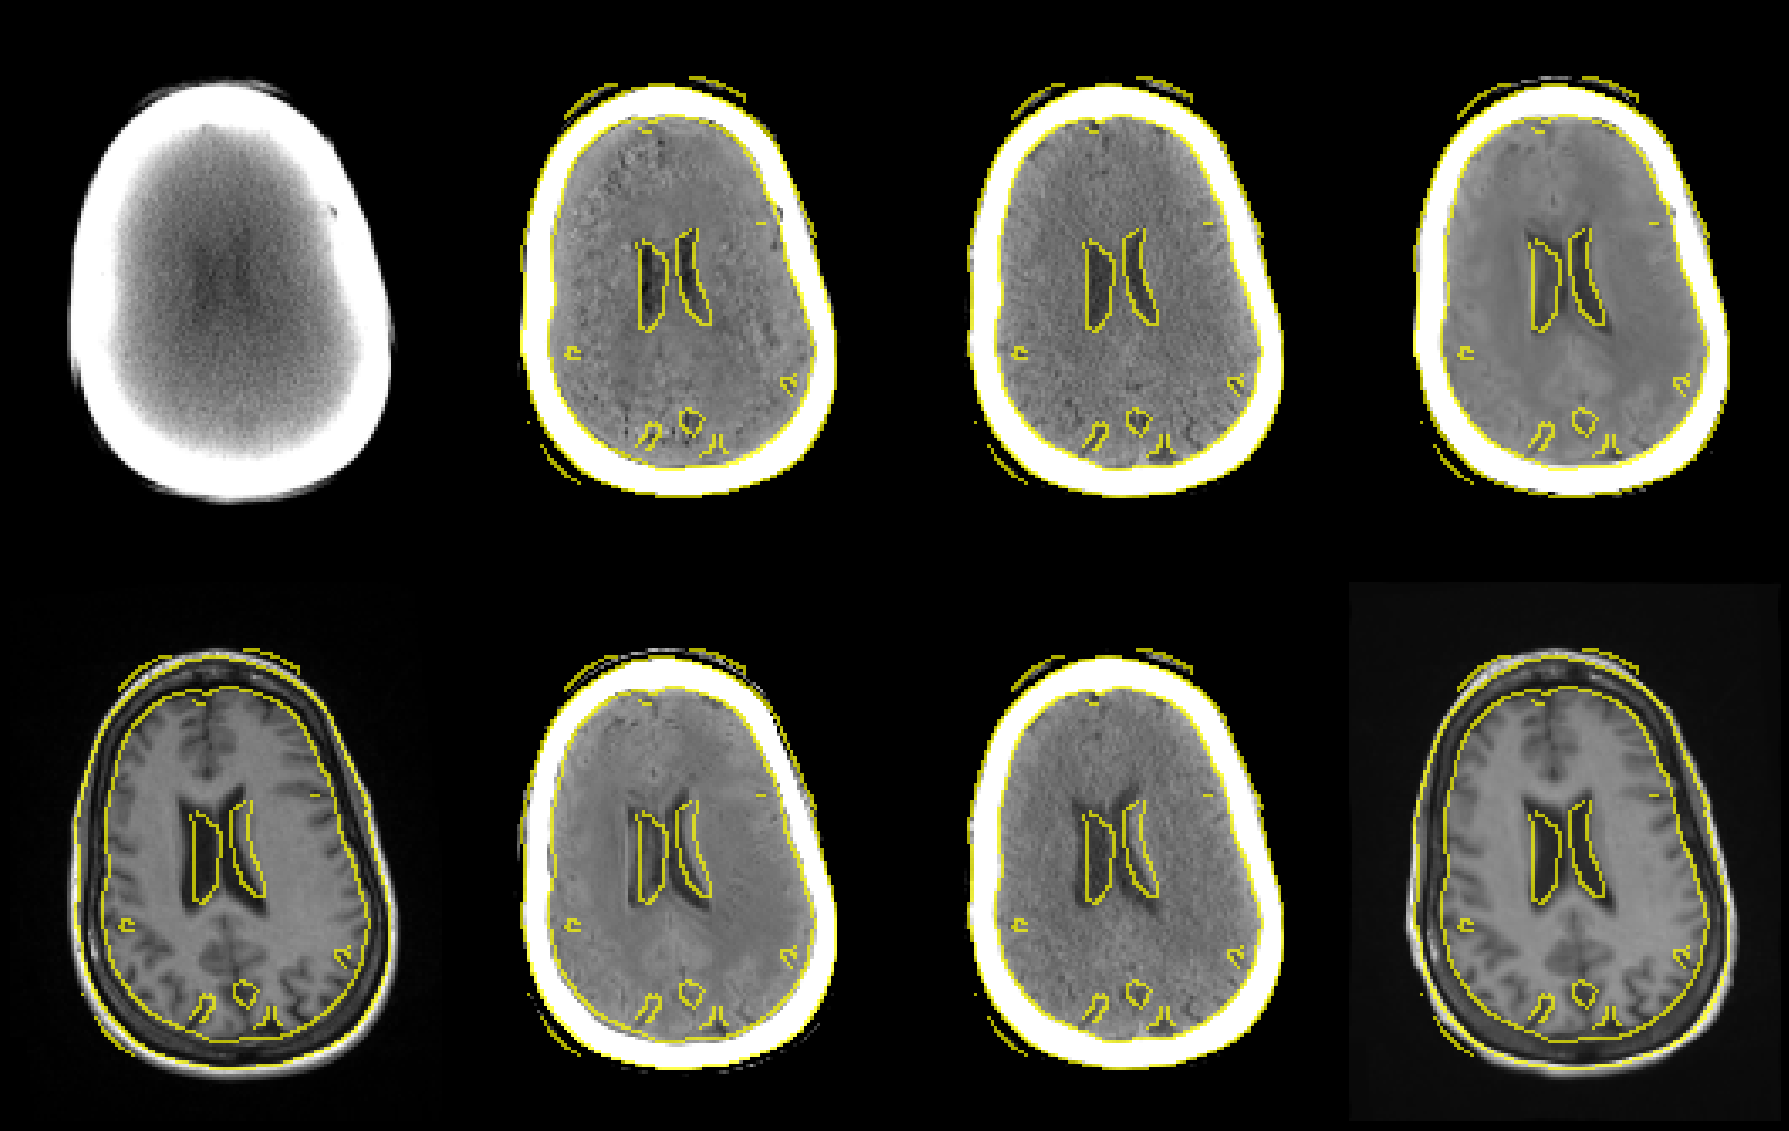

In [4]:
metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]
valid_dataset = RadOncValidationDataset("/mnt/blackhole-data2/RadOnc_Brain/Validation", num_samples=None, supervision=True,return_segmentation=True)
for ep in range(1):
    # checkpoint = torch.load(r'C:\Users\rhan5\Documents\GitHub\JSR\checkpoint\JSR\JSR__single_l1100_multi0.3_reg100_seg6_ep{}.pt'.format(ep*10+39))
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i, batch in enumerate(valid_dataset):
        cbct_fixed, mr_moving, ct_fixed, ct_moving, seg_fixed, seg_moving = batch
        cbct_fixed = cbct_fixed.float().to(device)
        mr_moving = mr_moving.float().to(device)
        ct_fixed = ct_fixed.float().to(device)
        ct_moving = ct_moving.float().to(device)
        seg_fixed = seg_fixed.float().to(device)
        seg_moving = seg_moving.float().to(device)

        with torch.no_grad():
            flow, ct_moving_synth, ct_fixed_synth = G(mr_moving, cbct_fixed)

            # the flow[0] means the final highest resolution from the cascade network.
            mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])
            ct_reg_synth = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], flow[0])
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])

            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            valid_ds = np.load(glob.glob(os.path.join("/mnt/blackhole-data2/RadOnc_Brain/Validation",'*.npz'))[i])
            seg_fixed = valid_ds['ventricle_fixed']
            seg_moving = valid_ds['ventricle_moving']

            seg_fixed = torch.from_numpy(resize(seg_fixed, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_moving = torch.from_numpy(resize(seg_moving, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            tre_before_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_moving.squeeze().cpu().numpy(), [1,1,1]).mean())
            tre_after_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_reg.squeeze().cpu().numpy(), [1,1,1]).mean())
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
            
            islice = 72
            fig, ax = plt.subplots(2,4,figsize=(18,12))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            ax[0,0].imshow(cbct_fixed.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[0,1].imshow(ct_fixed_synth[0].cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0,2].imshow(ct_fixed.cpu().numpy()[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0,3].imshow(ct_reg_synth.cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[0,3].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))

            ax[1,0].imshow(mr_moving.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[1,0].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,1].imshow(ct_moving_synth[0].cpu().numpy()[0,0,:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[1,1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,2].imshow(ct_moving.cpu().numpy()[:,:,islice].T, cmap='gray', vmin=0.4, vmax=0.95)
            ax[1,2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1,3].imshow(mr_reg.cpu().numpy()[0,0,:,:,islice].T, cmap='gray')
            ax[1,3].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            plt.tight_layout()
            plt.show()

           
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1),
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[0]*70, 'method':['Rigid']*70}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])
        
    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1),
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[29+ep*10]*70, 'method':['JSR-Single']*70}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])

In [11]:
sum_dice = 0
sum_hd = 0
sum_sd = 0
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Single']
    sum_dice += data['Dice'].mean()
    sum_hd += data['HD'].mean()
    sum_sd += data['SD'].mean()
    Dice = data['Dice'].mean()
    
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

3rd Ventricle 0.48798622041940687 3.0249586032220437 0.7167552718620172
4th Ventricle 0.46542403399944304 4.309594352132718 0.8683515917107197
Lateral Ventricles 0.7207829475402832 4.358012947282136 0.765037762545993
Amygdala 0.4812231421470642 3.922884729124424 0.8438615546595637
Hippocampus 0.5476525515317917 3.8306302402228796 0.7804734898869995
Thalamus 0.7545401275157928 3.9578423658679247 0.7607631911741819
Caudate 0.5588429272174835 4.208859542620518 0.7128631786112178
